# バンディットの実験に便利なコード

タイトルの通りです。よく使う関数をまとめます。

## 確率的バンディット

参考：
* [Bandit Algorithms](https://tor-lattimore.com/downloads/book/book.pdf)

確率的バンディット（の環境）は次で定義されます。

* $\mathcal{A}$：選択可能な行動の集合
    * 有限な場合はアームの数＝$A$とします
* $\nu=\left(P_a: a \in \mathcal{A}\right)$：各行動に設定された報酬の分布

また、$\mathcal{A}$が有限であり、次のような性質を満たす分布$\mathcal{M}_a$が存在する場合、そのバンディットの集合は「Unstructuredである」と言います。

$$
\mathcal{E}=\left\{\nu=\left(P_a: a \in \mathcal{A}\right): P_a \in \mathcal{M}_a \text { for all } a \in \mathcal{A}\right\}=\times_{a \in \mathcal{A}} \mathcal{M}_a
$$

以下のUnstructuredな確率的バンディットはよく出てきます。

|           Name          |                       Symbol                       |                                                                     Definition                                                                    |
|:-----------------------:|:--------------------------------------------------:|:-------------------------------------------------------------------------------------------------------------------------------------------------:|
|        Bernoulli        |            $\mathcal{E}_{\mathcal{B}}^A$           |                                   $\left\{\left(\mathcal{B}\left(\mu_i\right)\right)_i: \mu \in[0,1]^A\right\}$                                   |
|         Uniform         |            $\mathcal{E}_{\mathcal{U}}^A$           |        $\left\{\left(\mathcal{U}\left(a_i, b_i\right)\right)_i: a, b \in \mathbb{R}^A\right.$ with $a_i \leq b_i$ for all $\left.i\right\}$       |
|  Gaussian (known var.)  | $\mathcal{E}_{\mathcal{N}}^A\left(\sigma^2\right)$ |                           $\left\{\left(\mathcal{N}\left(\mu_i, \sigma^2\right)\right)_i: \mu \in \mathbb{R}^A\right\}$                           |
| Gaussian (unknown var.) |            $\mathcal{E}_{\mathcal{N}}^A$           | $\left\{\left(\mathcal{N}\left(\mu_i, \sigma_i^2\right)\right)_i: \mu \in \mathbb{R}^A \; \text{ and } \; \sigma^2 \in[0, \infty)^A\right\}$ |
|     Finite variance     |  $\mathcal{E}_{\mathbb{V}}^A\left(\sigma^2\right)$ |                             $\left\{\left(P_i\right)_i: \mathbb{V}_{X \sim P_i}[X] \leq \sigma^2\; \forall i\right\}$                             |

基本のバンディットをいくつか実装しておきます。

In [1]:
import jax.numpy as jnp
from jax.random import PRNGKey
import jax
from typing import NamedTuple
from typing_extensions import Self

key = PRNGKey(0)

A = 5  # アームの数
A_set = jnp.arange(A)  # アームの集合


# BernoulliBanditを実装します
key, _ = jax.random.split(key)
rew_mean = jax.random.uniform(key=key, shape=(A,))


class BernoulliBandit(NamedTuple):
    A_set: jnp.array  # 行動集合
    rew_mean: jnp.array  # 各アームの報酬の期待値

    @property
    def A(self) -> int:  # アームの数
        return len(self.A_set)
   
    @staticmethod
    def pull(bandit: Self, key: PRNGKey, arm: int):
        key, _ = jax.random.split(key)
        rew = jax.random.bernoulli(key, bandit.rew_mean[arm])
        return key, jnp.array(rew, dtype=jnp.float32)

bernoulli_bandit = BernoulliBandit(A_set, rew_mean)
print("平均報酬", bernoulli_bandit.rew_mean)
print("アームを引いて出た報酬", bernoulli_bandit.pull(bernoulli_bandit, key, 2)[1])


# GaussianBanditを実装します
key_mean, key_var, key = jax.random.split(key, num=3)
rew_mean = jax.random.uniform(key=key_mean, shape=(A,))
rew_var = jax.random.uniform(key=key_var, shape=(A,))


class GaussianBandit(NamedTuple):
    A_set: jnp.array  # 行動集合
    rew_mean: jnp.array  # 各アームの報酬の期待値
    rew_var: jnp.array  # 各アームの報酬の期待値

    @property
    def A(self) -> int:  # アームの数
        return len(self.A_set)

    @staticmethod
    def pull(bandit: Self, key: PRNGKey, arm: int):
        key, _ = jax.random.split(key)
        rew = jax.random.normal(key) * jnp.sqrt(bandit.rew_var[arm]) + bandit.rew_mean[arm]
        return key, jnp.array(rew, dtype=jnp.float32)


gaussian_bandit = GaussianBandit(A_set, rew_mean, rew_var)
print("平均報酬", gaussian_bandit.rew_mean)
print("アームを引いて出た報酬", gaussian_bandit.pull(gaussian_bandit, key, 2)[1])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


平均報酬 [0.72542226 0.58597934 0.9922459  0.51303005 0.8881017 ]
アームを引いて出た報酬 1.0
平均報酬 [0.08185661 0.58915615 0.24576998 0.5304918  0.2302388 ]
アームを引いて出た報酬 0.16982543


## 実装したアルゴリズム

* ``pull_all``：各アームを順番に引くアルゴリズム
* ``ETC``：[ETCアルゴリズム](BANDIT_basics.ipynb)
* ``UCB``：[UCBアルゴリズム](BANDIT_basics.ipynb)
    * 証明：[BANDIT_UCB_regret_proof.ipynb](BANDIT_UCB_regret_proof.ipynb)
* ``EXP3``：[EXP3アルゴリズム](BANDIT_adversarial.ipynb)
    * 証明：[BANDIT_adversarial.ipynb](BANDIT_adversarial.ipynb)
    * 敵対的バンディットですが、同じ確率的バンディットにも実装できます。

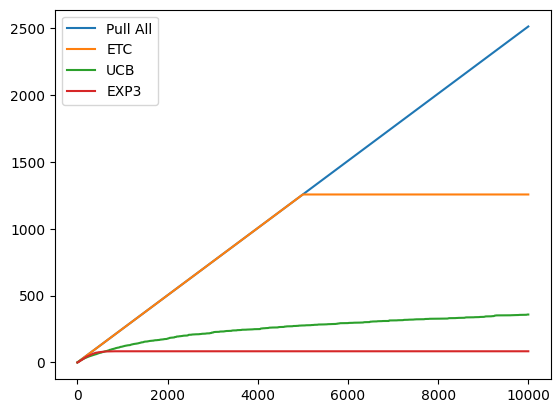

In [2]:
import jax.numpy as jnp
from jax.random import PRNGKey
from functools import partial
import jax


@partial(jax.jit, static_argnames=("num_round"))
def pull_all(bandit, key: PRNGKey, num_round: int):

    best_rew_mean = jnp.max(bandit.rew_mean)
    A = bandit.A

    def body_fn(round, args):
        key, rew_sum, num_arm_pulled, pseudo_rew_gaps = args

        # アームを順番に選択します
        arm = round % A
        key, rew = bandit.pull(bandit, key, arm)

        # 記録の更新
        num_arm_pulled = num_arm_pulled.at[arm].add(1.0)
        rew_sum = rew_sum.at[arm].add(rew)

        # 結果の記録
        rew_gap = best_rew_mean - bandit.rew_mean[arm]
        pseudo_rew_gaps = pseudo_rew_gaps.at[round].set(rew_gap)
        return key, rew_sum, num_arm_pulled, pseudo_rew_gaps

    pseudo_rew_gaps = jnp.zeros(num_round)
    rew_sum = jnp.zeros(A)
    num_arm_pulled = jnp.ones(A)
    args = key, rew_sum, num_arm_pulled, pseudo_rew_gaps
    args = jax.lax.fori_loop(0, num_round, body_fn, args)
    key, rew_sum, num_arm_pulled, pseudo_rew_gaps = args
    return key, rew_sum, num_arm_pulled, pseudo_rew_gaps


@partial(jax.jit, static_argnames=("m", "num_round"))
def ETC(bandit, key: PRNGKey, m: int, num_round: int):

    best_rew_mean = jnp.max(bandit.rew_mean)
    A = bandit.A

    # 最初にmA回引きます
    key, rew_sum, num_arm_pulled, pseudo_rew_gaps = pull_all(bandit, key, m * A)
    greedy_arm = jnp.argmax(rew_sum / num_arm_pulled)

    def body_fn(round, args):
        key, pseudo_rew_gaps = args

        # 貪欲に引きます
        key, _ = bandit.pull(bandit, key, greedy_arm)

        # 結果の記録
        rew_gap = best_rew_mean - bandit.rew_mean[greedy_arm]
        pseudo_rew_gaps = pseudo_rew_gaps.at[round].set(rew_gap)
        return key, pseudo_rew_gaps

    # 貪欲に引きます
    pseudo_rew_gaps = jnp.hstack((pseudo_rew_gaps, jnp.zeros(num_round - m * A)))
    args = key, pseudo_rew_gaps
    args = jax.lax.fori_loop(m * A, num_round, body_fn, args)
    key, pseudo_rew_gaps = args
    return key, pseudo_rew_gaps


@partial(jax.jit, static_argnames=("num_round"))
def UCB(bandit, key: PRNGKey, num_round: int):

    best_rew_mean = jnp.max(bandit.rew_mean)
    A = bandit.A

    # 最初に全部1回ずつ引きます
    key, rew_sum, num_arm_pulled, pseudo_rew_gaps = pull_all(bandit, key, A)

    def body_fn(round, args):
        key, rew_sum, num_arm_pulled, pseudo_rew_gaps = args
        rew_mean = rew_sum / num_arm_pulled

        # UCBスコアを計算してアームを引きます
        delta = 1 / (num_round ** 2)
        ucb = rew_mean + jnp.sqrt(2 * jnp.log(1 / delta) / num_arm_pulled)
        arm = jnp.argmax(ucb)
        key, rew = bandit.pull(bandit, key, arm)

        # 記録の更新
        num_arm_pulled = num_arm_pulled.at[arm].add(1.0)
        rew_sum = rew_sum.at[arm].add(rew)

        # 結果の記録
        rew_gap = best_rew_mean - bandit.rew_mean[arm]
        pseudo_rew_gaps = pseudo_rew_gaps.at[round].set(rew_gap)
        return key, rew_sum, num_arm_pulled, pseudo_rew_gaps

    # UCBを実行します
    pseudo_rew_gaps = jnp.hstack((pseudo_rew_gaps, jnp.zeros(num_round - A)))
    args = key, rew_sum, num_arm_pulled, pseudo_rew_gaps
    args = jax.lax.fori_loop(A, num_round, body_fn, args)
    key, rew_sum, num_arm_pulled, pseudo_rew_gaps = args
    return key, rew_sum, num_arm_pulled, pseudo_rew_gaps


@partial(jax.jit, static_argnames=("num_round"))
def EXP3(bandit, key: PRNGKey, num_round: int):

    best_rew_mean = jnp.max(bandit.rew_mean)
    A = bandit.A
    eta = 2 * jnp.sqrt(jnp.log(A) / (num_round * A))

    def body_fn(round, args):
        key, rew_sum, pseudo_rew_gaps = args

        key, sample_key = jax.random.split(key)
        arm = jax.random.categorical(sample_key, eta * rew_sum)
        key, rew = bandit.pull(bandit, key, arm)

        # 記録の更新
        prob = jax.nn.softmax(eta * rew_sum)[arm]
        rew_t_estimate = 1 - (1 - rew) / prob
        rew_sum = rew_sum.at[arm].add(rew_t_estimate)

        # 結果の記録
        rew_gap = best_rew_mean - bandit.rew_mean[arm]
        pseudo_rew_gaps = pseudo_rew_gaps.at[round].set(rew_gap)
        return key, rew_sum, pseudo_rew_gaps

    # EXP3を実行します
    rew_sum = jnp.zeros(A)
    pseudo_rew_gaps = jnp.zeros(num_round)
    args = key, rew_sum, pseudo_rew_gaps
    args = jax.lax.fori_loop(A, num_round, body_fn, args)
    key, rew_sum, pseudo_rew_gaps = args
    return key, rew_sum, pseudo_rew_gaps


# テスト

import matplotlib.pyplot as plt
key = PRNGKey(0)
num_round = 10000

key, *_, num_arm_pulled, pseudo_rew_gaps = pull_all(bernoulli_bandit, key, num_round)
plt.plot(jnp.cumsum(pseudo_rew_gaps), label="Pull All")

key, *_, pseudo_rew_gaps = ETC(bernoulli_bandit, key, int(num_round / 10), num_round)
plt.plot(jnp.cumsum(pseudo_rew_gaps), label="ETC")

key, *_, pseudo_rew_gaps = UCB(bernoulli_bandit, key, num_round)
plt.plot(jnp.cumsum(pseudo_rew_gaps), label="UCB")

key, *_, pseudo_rew_gaps = EXP3(bernoulli_bandit, key, num_round)
plt.plot(jnp.cumsum(pseudo_rew_gaps), label="EXP3")

plt.legend()